# W266 Final Project

## Downloads

In [ ]:
pip install transformers

     |████████████████████████████████| 2.2MB 6.7MB/s 
     |████████████████████████████████| 870kB 50.9MB/s 
     |████████████████████████████████| 3.3MB 39.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=e12e5e607a50adfdf3a91b23f8134500e0b09e3a6bb04210f7f7b5635c44425f
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


## Setup

In [ ]:
import numpy as np333iaamport pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from time import time
from scipy.sparse import hstack, csr_matrix
from random import sample

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.optimizers import SGD, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC

import tensorflow_datasets as tfds
import tensorflow as tf

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import RobertaTokenizer, TFRobertaModel, TFRobertaForSequenceClassification

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 

%matplotlib inline
tfds.disable_progress_bar()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./valid.csv")

In [ ]:
def get_incorrect_predictions(inputs, labels, predictions):
  wrong_indices = []
  for i in range(len(predictions)):
    if predictions[i] != labels.tolist()[i]:
      wrong_indices.append(i)
  copy = inputs.copy()
  copy["Predicted"] = predictions
  return copy.iloc[wrong_indices]

def get_correct_predictions(inputs, labels, predictions):
  correct_indices = []
  for i in range(len(predictions)):
    if predictions[i] == labels.tolist()[i]:
      correct_indices.append(i)
  copy = inputs.copy()
  copy["Predicted"] = predictions
  return copy.iloc[correct_indices]

## Data Cleaning

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(train_data.drop("Id", 1).drop("CreationDate", 1), train_data["Y"], test_size=15000)

test_x = test_data.drop("Id", 1).drop("CreationDate", 1)
test_y = test_data["Y"]

In [ ]:
def cleanText(text):
    return re.sub(' +', ' ', re.sub(r"<.*?>", " ", text).replace("\n", " ").replace("\r", " ")).lower()

def cleanTags(text):
    return text.replace("><"," ").replace(">", "").replace("<", "").lower()

In [ ]:
def extract_title_from_dataset(ds):
    return ds['Title'].apply(lambda title: cleanText(title))

def extract_body_from_dataset(ds):
    return ds['Body'].apply(lambda body: cleanText(body))

def extract_tags_from_dataset(ds):
    return ds['Tags'].apply(lambda tags: cleanTags(tags))

train_x_title = extract_title_from_dataset(train_x)
train_x_body = extract_body_from_dataset(train_x)
train_x_tags = extract_tags_from_dataset(train_x)

valid_x_title = extract_title_from_dataset(valid_x)
valid_x_body = extract_body_from_dataset(valid_x)
valid_x_tags = extract_tags_from_dataset(valid_x)

test_x_title = extract_title_from_dataset(test_x)
test_x_body = extract_body_from_dataset(test_x)
test_x_tags = extract_tags_from_dataset(test_x)

In [ ]:
pd.set_option('display.max_colwidth', None)
train_x_cleaned = train_x.copy()
train_x_cleaned["Title"] = train_x_title
train_x_cleaned["Body"] = train_x_body
train_x_cleaned["Tags"] = train_x_tags

valid_x_cleaned = valid_x.copy()
valid_x_cleaned["Title"] = valid_x_title
valid_x_cleaned["Body"] = valid_x_body
valid_x_cleaned["Tags"] = valid_x_tags

test_x_cleaned = test_x.copy()
test_x_cleaned["Title"] = test_x_title
test_x_cleaned["Body"] = test_x_body
test_x_cleaned["Tags"] = test_x_tags

In [ ]:
train_x_cleaned.head()

,Title,Body,Tags,Y
19086,(swift ios) getting all numbers below a certain integer,"quick question. i was wondering how to be able to get all the numbers below a certain integer. so like if the number is 5, it should get 4,3,2,1,",swift swift3,LQ_EDIT
5697,javascript - output random object from array of objects,"quick question, i have an array of objects: var objects = [ {username: jon, count: 5}, {username: sally, count: 7}, {username: mark, count: 9, ] i want to output one of these objects at random so that i can access its properties and not just it's index. how do i do this?",javascript arrays object random,LQ_CLOSE
4841,help to using switch case in c++?,"how do i use switch case in this code ?? i have tried several times , but i really do not know how to make it without error . i don't know anywhere i put it ?? #include int x,y; int sum(int a,int b) { int c; c = a+b; return (c); } int sub (int a ,int b) { int c; c = a-b ; return (c); } int multi ( int a, int b ) { int c ; c = a*b; return (c); } float div ( int a , int b) { float c; c = a/b ; return (c); } main() { cout<<""enter the value of x = ""; cin>>x; cout<<""enter the value of y = ""; cin>>y; cout<<""x + y = ""<< sum(x,y); cout<<""\n x - y = ""<< sub(x,y); cout<<""\n x * y = ""<< multi(x,y); cout<<""\n x /y = ""<< div (x,y); cin>>""\n""; }",c++ switch-statement,LQ_EDIT
20993,insert data to database using foreach loop php,"ex: if i have code : $data = array('a','b','c'); foreach($data as $val){ mysql_query(""insert into db (`title`)values('$val')""); } i want to insert all data from variable $val how can i coding it ? please help !!! thank !!",php,LQ_CLOSE
13169,git hangs macos sierra terminal with no recovery,"running git version 2.10.2 (from homebrew) on macos sierra 10.12.1. when i perform a git pull it completely hangs my terminal. if i force quit terminal and relaunch then terminal will not start. i've tried the following (from other answers): change over from using dsa keys to rsa keys (due to deprecation of rsa in the latest openssh) updated to the latest homebrew and updated git tried a different terminal (iterm) ensured xcode is up-to-date and reinstalled commandline tools (xcode-select --install) the fact that it completely hangs terminal and can't recover makes it very hard to diagnose and it seems to mess with a number of other apps after this, requiring a complete reboot. any help gratefully received!",git terminal macos-sierra,HQ


## EDA

In [ ]:
def plot_top_stopwords(text, n=10): 
    stop_words = set(stopwords.words('english'))   
    samples = text.str.split().values.tolist()
    corpus = [word for sample in samples for word in sample]
    word_counts = defaultdict(int)
  
    for word in corpus:
        if word in stop_words:
            word_counts[word] += 1
            
    top = sorted(word_counts.items(), key=lambda x:x[1], reverse=True)[:n]
    words = [x[1] for x in top]
    counts = [x[0] for x in top] 

    sns.barplot(x=words, y=counts)

    return top

def plot_top_non_stopwords(text, n=10): 
    stop_words = set(stopwords.words('english'))   
    samples = text.str.split().values.tolist()
    corpus = [word for sample in samples for word in sample]
    word_counts = defaultdict(int)

    for word in corpus:
      if word not in stop_words:
          word_counts[word] += 1
            
    top = sorted(word_counts.items(), key=lambda x:x[1], reverse=True)[:n]
    words = [x[1] for x in top]
    counts = [x[0] for x in top] 

    sns.barplot(x=words, y=counts)

    return top

def plot_top_ngram_counts(corpus, n=2, top=20):
    cv = CountVectorizer(ngram_range=(n, n))
    counts = cv.fit_transform(corpus).sum(axis=0)
    word_counts = [(word, counts[0, index]) for word, index in cv.vocabulary_.items()]
    sorted_word_counts = sorted(word_counts, key=lambda x: x[1], reverse=True)

    top_words = sorted_word_counts[:top]
    words = [x[1] for x in top_words]
    counts = [x[0] for x in top_words]
  
    sns.barplot(x=words, y=counts)

    return top_words

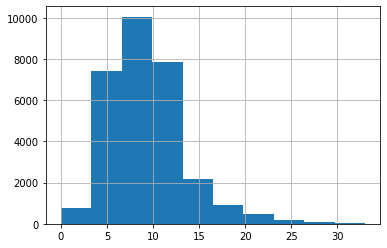

In [ ]:
train_x_title.str.split().map(lambda x: len(x)).hist()

[('to', 11890),
 ('in', 10440),
 ('how', 7543),
 ('a', 6961),
 ('the', 5149),
 ('of', 3863),
 ('i', 3575),
 ('is', 3355),
 ('and', 3301),
 ('with', 3181)]

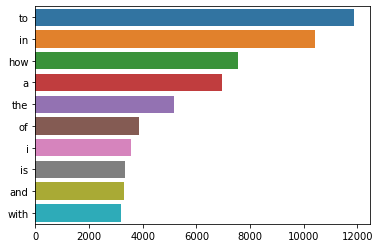

In [ ]:
plot_top_stopwords(train_x_title)

[('using', 1989),
 ('-', 1502),
 ('python', 1224),
 ('get', 1211),
 ('string', 1198),
 ('array', 1170),
 ('error', 1130),
 ('file', 1074),
 ('android', 1035),
 ('use', 1020)]

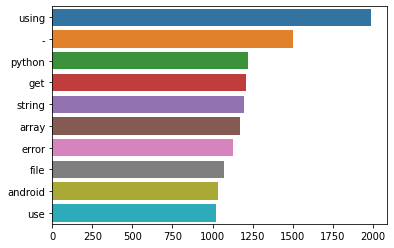

In [ ]:
plot_top_non_stopwords(train_x_title)

[('how to', 5372),
 ('how can', 914),
 ('how do', 742),
 ('what is', 634),
 ('to get', 564),
 ('in python', 514),
 ('is the', 506),
 ('to use', 467),
 ('is not', 458),
 ('not working', 408),
 ('in java', 387),
 ('in the', 381),
 ('in android', 361),
 ('way to', 322),
 ('to create', 319),
 ('difference between', 307),
 ('an array', 299),
 ('android studio', 285),
 ('want to', 284),
 ('to make', 281)]

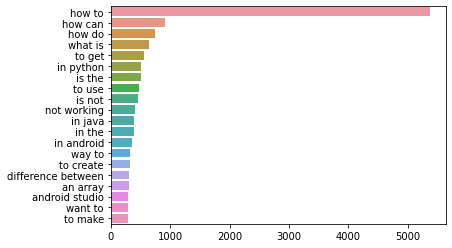

In [ ]:
plot_top_ngram_counts(train_x_title, 2)

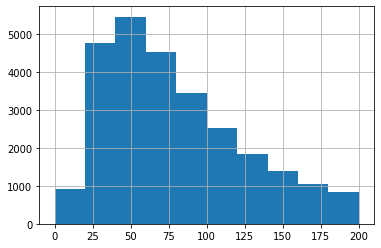

In [ ]:
train_x_body.str.split().map(lambda x: len(x)).hist(range=[0, 200])

[('the', 101761),
 ('i', 87441),
 ('to', 76648),
 ('a', 49978),
 ('is', 43049),
 ('in', 40369),
 ('and', 39963),
 ('of', 28991),
 ('this', 24408),
 ('it', 24066)]

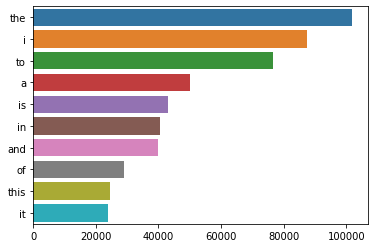

In [ ]:
plot_top_stopwords(train_x_body)

[('=', 58490),
 ('{', 41053),
 ('}', 38700),
 ('new', 11681),
 ('using', 10245),
 ('want', 9605),
 ('public', 9451),
 ('code', 9292),
 ('like', 9219),
 ('return', 9134)]

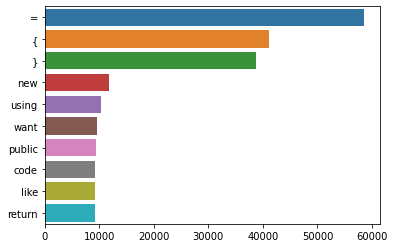

In [ ]:
plot_top_non_stopwords(train_x_body)

[('gt lt', 18446),
 ('want to', 7423),
 ('in the', 7421),
 ('of the', 6358),
 ('trying to', 4684),
 ('how to', 4557),
 ('this is', 4295),
 ('is the', 4213),
 ('to the', 4006),
 ('lt div', 3602),
 ('the following', 3458),
 ('lt lt', 3451),
 ('need to', 3434),
 ('how can', 3415),
 ('to do', 3201),
 ('to be', 3170),
 ('on the', 2956),
 ('is not', 2882),
 ('is there', 2866),
 ('to use', 2777)]

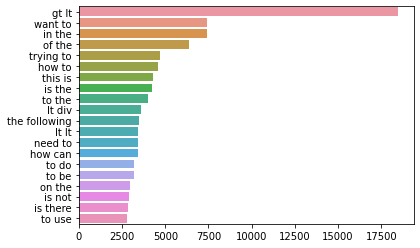

In [ ]:
plot_top_ngram_counts(train_x_body, 2)

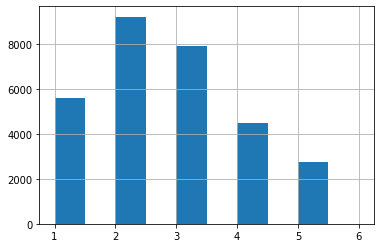

In [ ]:
train_x_tags.str.split().map(lambda x: len(x)).hist()

[('this', 8),
 ('having', 2),
 ('each', 2),
 ('between', 2),
 ('m', 2),
 ('where', 2),
 ('ll', 1),
 ('any', 1)]

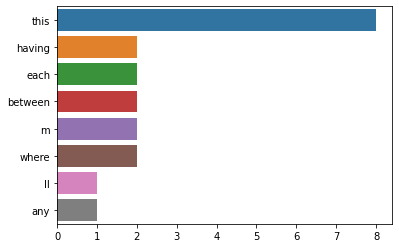

In [ ]:
plot_top_stopwords(train_x_tags)

[('javascript', 3594),
 ('python', 3339),
 ('java', 3119),
 ('android', 2404),
 ('php', 2101),
 ('c#', 2081),
 ('html', 1714),
 ('c++', 1489),
 ('css', 1059),
 ('jquery', 962)]

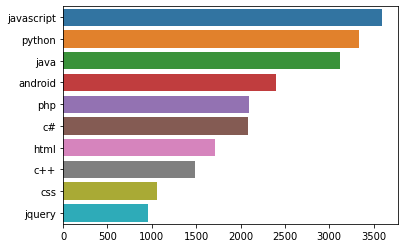

In [ ]:
plot_top_non_stopwords(train_x_tags)

[('asp net', 719),
 ('html css', 707),
 ('javascript jquery', 669),
 ('python python', 660),
 ('java android', 640),
 ('android android', 619),
 ('sql server', 616),
 ('node js', 532),
 ('visual studio', 522),
 ('javascript html', 439),
 ('ios swift', 393),
 ('net core', 360),
 ('php mysql', 346),
 ('jquery html', 336),
 ('react native', 302),
 ('android studio', 284),
 ('php html', 280),
 ('sql sql', 274),
 ('javascript php', 240),
 ('python pandas', 223)]

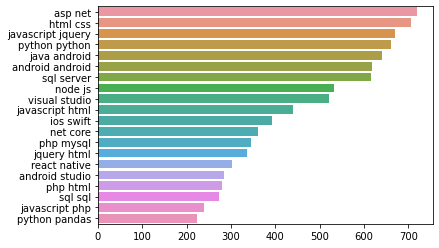

In [ ]:
plot_top_ngram_counts(train_x_tags, 2)

## Feature Engineering

In [ ]:
def transform_to_sparse_matrix(data, column_name, cb):
    return csr_matrix([[cb(val)] for val in data[column_name]])

def get_length(val):
    return len(str(val).split())

train_x_title_length = transform_to_sparse_matrix(train_x, "Title", get_length)
train_x_body_length = transform_to_sparse_matrix(train_x, "Body", get_length)
train_x_tag_length = transform_to_sparse_matrix(train_x, "Tags", get_length)

valid_x_title_length = transform_to_sparse_matrix(valid_x, "Title", get_length)
valid_x_body_length = transform_to_sparse_matrix(valid_x, "Body", get_length)
valid_x_tag_length = transform_to_sparse_matrix(valid_x, "Tags", get_length)

test_x_title_length = transform_to_sparse_matrix(test_x, "Title", get_length)
test_x_body_length = transform_to_sparse_matrix(test_x, "Body", get_length)
test_x_tag_length = transform_to_sparse_matrix(test_x, "Tags", get_length)

## Word Embeddings

### Tfidf

In [ ]:
title_vectorizer = TfidfVectorizer(analyzer='word', stop_words ='english')
train_x_title_embeddings = title_vectorizer.fit_transform(train_x_title)
valid_x_title_embeddings = title_vectorizer.transform(valid_x_title)
test_x_title_embeddings = title_vectorizer.transform(test_x_title)

body_vectorizer = TfidfVectorizer(analyzer='word', stop_words ='english')
train_x_body_embeddings = body_vectorizer.fit_transform(train_x_body)
valid_x_body_embeddings = body_vectorizer.transform(valid_x_body)
test_x_body_embeddings = body_vectorizer.transform(test_x_body)

tags_vectorizer = TfidfVectorizer(analyzer='word', stop_words ='english')
train_x_tag_embeddings = tags_vectorizer.fit_transform(train_x_tags)
valid_x_tag_embeddings = tags_vectorizer.transform(valid_x_tags)
test_x_tag_embeddings = tags_vectorizer.transform(test_x_tags)

In [ ]:
train_x_tfidf_embeddings = hstack((
    train_x_title_embeddings, 
    train_x_body_embeddings, 
    train_x_tag_embeddings, 
    train_x_title_length, 
    train_x_body_length, 
    train_x_tag_length
))

valid_x_tfidf_embeddings = hstack((
    valid_x_title_embeddings, 
    valid_x_body_embeddings, 
    valid_x_tag_embeddings, 
    valid_x_title_length, 
    valid_x_body_length, 
    valid_x_tag_length
))

test_x_tfidf_embeddings = hstack((
    test_x_title_embeddings, 
    test_x_body_embeddings, 
    test_x_tag_embeddings, 
    test_x_title_length, 
    test_x_body_length, 
    test_x_tag_length
))

### Doc2Vec

In [ ]:
doc2vec_title = Doc2Vec(vector_size=300, min_count=2)
doc2vec_body = Doc2Vec(vector_size=300, min_count=2)
doc2vec_tags = Doc2Vec(vector_size=300, min_count=2)

title_corpus = [TaggedDocument(title.split(), [i]) for i, title in enumerate(train_x["Title"])]
body_corpus = [TaggedDocument(body.split(), [i]) for i, body in enumerate(train_x["Body"])]
tags_corpus = [TaggedDocument(tags.split(), [i]) for i, tags in enumerate(train_x["Tags"])]

doc2vec_title.build_vocab(title_corpus)
doc2vec_body.build_vocab(body_corpus)
doc2vec_tags.build_vocab(tags_corpus)

In [ ]:
doc2vec_title.train(title_corpus, total_examples=doc2vec_title.corpus_count, epochs=10)
doc2vec_body.train(body_corpus, total_examples=doc2vec_body.corpus_count, epochs=10)
doc2vec_tags.train(tags_corpus, total_examples=doc2vec_tags.corpus_count, epochs=10)

In [ ]:
doc2vec_title.init_sims(replace=True)
doc2vec_body.init_sims(replace=True)
doc2vec_tags.init_sims(replace=True)

In [ ]:
train_x_doc2vec_title_embeddings = [doc2vec_title.infer_vector(title.split()) for title in train_x_title]
train_x_doc2vec_body_embeddings = [doc2vec_body.infer_vector(body.split()) for body in train_x_body]
train_x_doc2vec_tag_embeddings = [doc2vec_tags.infer_vector(tag.split()) for tag in train_x_tags]

valid_x_doc2vec_title_embeddings = [doc2vec_title.infer_vector(title.split()) for title in valid_x_title]
valid_x_doc2vec_body_embeddings = [doc2vec_body.infer_vector(body.split()) for body in valid_x_body]
valid_x_doc2vec_tag_embeddings = [doc2vec_tags.infer_vector(tag.split()) for tag in valid_x_tags]

test_x_doc2vec_title_embeddings = [doc2vec_title.infer_vector(title.split()) for title in test_x_title]
test_x_doc2vec_body_embeddings = [doc2vec_body.infer_vector(body.split()) for body in test_x_body]
test_x_doc2vec_tag_embeddings = [doc2vec_tags.infer_vector(tag.split()) for tag in test_x_tags]

In [ ]:
title_scaler = MinMaxScaler(feature_range=(0,1))
body_scaler = MinMaxScaler(feature_range=(0,1))
tag_scaler = MinMaxScaler(feature_range=(0,1))

title_scaler.fit(train_x_doc2vec_title_embeddings)
body_scaler.fit(train_x_doc2vec_body_embeddings)
tag_scaler.fit(train_x_doc2vec_tag_embeddings)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
train_x_doc2vec_normalized_title_embeddings = title_scaler.transform(train_x_doc2vec_title_embeddings)
train_x_doc2vec_normalized_body_embeddings = body_scaler.transform(train_x_doc2vec_body_embeddings)
train_x_doc2vec_normalized_tag_embeddings = tag_scaler.transform(train_x_doc2vec_tag_embeddings)

valid_x_doc2vec_normalized_title_embeddings = title_scaler.transform(valid_x_doc2vec_title_embeddings)
valid_x_doc2vec_normalized_body_embeddings = body_scaler.transform(valid_x_doc2vec_body_embeddings)
valid_x_doc2vec_normalized_tag_embeddings = tag_scaler.transform(valid_x_doc2vec_tag_embeddings)

test_x_doc2vec_normalized_title_embeddings = title_scaler.transform(test_x_doc2vec_title_embeddings)
test_x_doc2vec_normalized_body_embeddings = body_scaler.transform(test_x_doc2vec_body_embeddings)
test_x_doc2vec_normalized_tag_embeddings = tag_scaler.transform(test_x_doc2vec_tag_embeddings)

In [ ]:
train_x_doc2vec_embeddings = hstack((train_x_doc2vec_normalized_title_embeddings, train_x_doc2vec_normalized_body_embeddings, train_x_doc2vec_normalized_tag_embeddings, train_x_title_length, train_x_body_length, train_x_tag_length))
valid_x_doc2vec_embeddings = hstack((valid_x_doc2vec_normalized_title_embeddings, valid_x_doc2vec_normalized_body_embeddings, valid_x_doc2vec_normalized_tag_embeddings, valid_x_title_length, valid_x_body_length, valid_x_tag_length))
test_x_doc2vec_embeddings = hstack((test_x_doc2vec_normalized_title_embeddings, test_x_doc2vec_normalized_body_embeddings, test_x_doc2vec_normalized_tag_embeddings, test_x_title_length, test_x_body_length, test_x_tag_length))

### Glove

In [ ]:
def get_word_embeddings_from_glove_file(file_name):
    word_to_embedding_mapping = {}
    
    with open(file_name, 'r') as file:
        for line in file:
            line_as_list = line.split()
            word = line_as_list[0]
            word_embedding = np.array(line_as_list[1:], dtype=np.float64)
            word_to_embedding_mapping[word] = word_embedding
            
    return word_to_embedding_mapping

glove_mapping = get_word_embeddings_from_glove_file("glove.twitter.27B.200d.txt")

In [ ]:
def get_sentence_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        sentence_embedding = np.zeros(glove_mapping['#'].shape)
        for word in sentence.split():
            if word in glove_mapping.keys():
                word_embedding = glove_mapping[word]
            else:
                word_embedding = glove_mapping['#']
            sentence_embedding = word_embedding / len(sentence)
        embeddings.append(sentence_embedding)
    return np.array(embeddings)

In [ ]:
train_x_glove_title_embeddings = get_sentence_embeddings(train_x_title)
train_x_glove_body_embeddings = get_sentence_embeddings(train_x_body)
train_x_glove_tag_embeddings = get_sentence_embeddings(train_x_tags)

valid_x_glove_title_embeddings = get_sentence_embeddings(valid_x_title)
valid_x_glove_body_embeddings = get_sentence_embeddings(valid_x_body)
valid_x_glove_tag_embeddings = get_sentence_embeddings(valid_x_tags)

test_x_glove_title_embeddings = get_sentence_embeddings(test_x_title)
test_x_glove_body_embeddings = get_sentence_embeddings(test_x_body)
test_x_glove_tag_embeddings = get_sentence_embeddings(test_x_tags)

In [ ]:
title_scaler = MinMaxScaler(feature_range=(0,1))
body_scaler = MinMaxScaler(feature_range=(0,1))
tag_scaler = MinMaxScaler(feature_range=(0,1))

title_scaler.fit(train_x_glove_title_embeddings)
body_scaler.fit(train_x_glove_body_embeddings)
tag_scaler.fit(train_x_glove_tag_embeddings)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
train_x_glove_normalized_title_embeddings = title_scaler.transform(train_x_glove_title_embeddings)
train_x_glove_normalized_body_embeddings = body_scaler.transform(train_x_glove_body_embeddings)
train_x_glove_normalized_tag_embeddings = tag_scaler.transform(train_x_glove_tag_embeddings)

valid_x_glove_normalized_title_embeddings = title_scaler.transform(valid_x_glove_title_embeddings)
valid_x_glove_normalized_body_embeddings = body_scaler.transform(valid_x_glove_body_embeddings)
valid_x_glove_normalized_tag_embeddings = tag_scaler.transform(valid_x_glove_tag_embeddings)

test_x_glove_normalized_title_embeddings = title_scaler.transform(test_x_glove_title_embeddings)
test_x_glove_normalized_body_embeddings = body_scaler.transform(test_x_glove_body_embeddings)
test_x_glove_normalized_tag_embeddings = tag_scaler.transform(test_x_glove_tag_embeddings)

In [ ]:
train_x_glove_embeddings = hstack((train_x_glove_normalized_title_embeddings, train_x_glove_normalized_body_embeddings, train_x_glove_normalized_tag_embeddings, train_x_title_length, train_x_body_length, train_x_tag_length))
valid_x_glove_embeddings = hstack((valid_x_glove_normalized_title_embeddings, valid_x_glove_normalized_body_embeddings, valid_x_glove_normalized_tag_embeddings, valid_x_title_length, valid_x_body_length, valid_x_tag_length))
test_x_glove_embeddings = hstack((test_x_glove_normalized_title_embeddings, test_x_glove_normalized_body_embeddings, test_x_glove_normalized_tag_embeddings, test_x_title_length, test_x_body_length, test_x_tag_length))

## Baseline Models

In [ ]:
def train_model(model, train_inputs, train_labels, valid_inputs):
    model.fit(train_inputs, train_labels)
    predictions = model.predict(valid_inputs)
    
    return predictions

In [ ]:
lr_model = LogisticRegression(max_iter=10000, C=1.0)
lr_predictions = train_model(lr_model, train_x_tfidf_embeddings, train_y, valid_x_tfidf_embeddings)

In [ ]:
print(classification_report(lr_predictions, valid_y))

              precision    recall  f1-score   support

          HQ       0.85      0.81      0.83      5194
    LQ_CLOSE       0.65      0.68      0.66      4878
     LQ_EDIT       0.70      0.71      0.70      4928

    accuracy                           0.73     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.74      0.73      0.74     15000



In [ ]:
# lr_model = LogisticRegression(max_iter = 1000)
# nb_model = MultinomialNB()
# ada_boost_model = AdaBoostClassifier()
# svm_model = SVC()

# models = [lr_model, nb_model, ada_boost_model, svm_model]
# train_embeddings =  [train_x_tfidf_embeddings, train_x_doc2vec_embeddings, train_x_glove_embeddings]
# valid_embeddings =  [valid_x_tfidf_embeddings, valid_x_doc2vec_embeddings, valid_x_glove_embeddings]

# for model in models:
#     for i in range(len(train_embeddings)):
#         print("embedding:", i)
#         predictions = train_model(model, train_embeddings[i], train_y, valid_embeddings[i])
#         score_report = classification_report(predictions, valid_y)
#         print(score_report)

In [ ]:
# stop = set(stopwords.words('english'))

# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer(stop_words=stop)),
#     ('lr', LogisticRegression(max_iter=10000))
# ])
# parameters = {
#     'tfidf__max_df': (0.25, 0.5, 0.75, 1),
#     'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)],
#     'lr__C': [100, 10, 1.0, 0.1, 0.01],
#     'lr__solver': ['newton-cg', 'lbfgs', 'liblinear']
# }

# baseline_grid_search = GridSearchCV(pipeline, parameters, cv=5)
# baseline_grid_search.fit(train_x_body, train_y)

## Neural Networks

### Shared API

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  tpu = None
  print('Not connected to TPU')

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)
else:
  tpu_strategy = tf.distribute.get_strategy()

Tensorflow version 2.4.1
Running on TPU  ['10.96.18.50:8470']


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.96.18.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.96.18.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(train_y.values)

train_y_encoded = label_encoder.transform(train_y.values)
valid_y_encoded = label_encoder.transform(valid_y.values)
test_y_encoded = label_encoder.transform(test_y.values)

train_y_one_hot_encoded = to_categorical(train_y_encoded)
valid_y_one_hot_encoded = to_categorical(valid_y_encoded)
test_y_one_hot_encoded = to_categorical(test_y_encoded)

In [ ]:
list(label_encoder.classes_)

['HQ', 'LQ_CLOSE', 'LQ_EDIT']

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+ metric])

### LSTM

In [ ]:
MAX_WORDS_PER_SEQUENCE = 10000
MAX_EMBEDDING_LENGTH = 500

title_tokzr = Tokenizer(num_words=MAX_WORDS_PER_SEQUENCE)
title_tokzr.fit_on_texts(train_x_title)

title_sequences = title_tokzr.texts_to_sequences(train_x_title)
title_sequences = sequence.pad_sequences(title_sequences, maxlen=MAX_EMBEDDING_LENGTH)

valid_title_sequences = title_tokzr.texts_to_sequences(valid_x_title)
valid_title_sequences = sequence.pad_sequences(valid_title_sequences, maxlen=MAX_EMBEDDING_LENGTH)

test_title_sequences = title_tokzr.texts_to_sequences(test_x_title)
test_title_sequences = sequence.pad_sequences(test_title_sequences, maxlen=MAX_EMBEDDING_LENGTH)

body_tokzr = Tokenizer(num_words=MAX_WORDS_PER_SEQUENCE)
body_tokzr.fit_on_texts(train_x_body)

body_sequences = body_tokzr.texts_to_sequences(train_x_body)
body_sequences = sequence.pad_sequences(body_sequences, maxlen=MAX_EMBEDDING_LENGTH)

valid_body_sequences = body_tokzr.texts_to_sequences(valid_x_body)
valid_body_sequences = sequence.pad_sequences(valid_body_sequences, maxlen=MAX_EMBEDDING_LENGTH)

test_body_sequences = body_tokzr.texts_to_sequences(test_x_body)
test_body_sequences = sequence.pad_sequences(test_body_sequences, maxlen=MAX_EMBEDDING_LENGTH)

tags_tokzr = Tokenizer(num_words=MAX_WORDS_PER_SEQUENCE)
tags_tokzr.fit_on_texts(train_x_tags)

tag_sequences = tags_tokzr.texts_to_sequences(train_x_tags)
tag_sequences = sequence.pad_sequences(tag_sequences, maxlen=MAX_EMBEDDING_LENGTH)

valid_tag_sequences = tags_tokzr.texts_to_sequences(valid_x_tags)
valid_tag_sequences = sequence.pad_sequences(valid_tag_sequences, maxlen=MAX_EMBEDDING_LENGTH)

test_tag_sequences = tags_tokzr.texts_to_sequences(test_x_tags)
test_tag_sequences = sequence.pad_sequences(test_tag_sequences, maxlen=MAX_EMBEDDING_LENGTH)

In [ ]:
combined_sequences = np.concatenate((title_sequences, body_sequences, tag_sequences), axis=1)
valid_combined_sequences = np.concatenate((valid_title_sequences, valid_body_sequences, valid_tag_sequences), axis=1)
test_combined_sequences = np.concatenate((test_title_sequences, test_body_sequences, test_tag_sequences), axis=1)

In [ ]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=8)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', patience=6)

In [79]:
def RNN():
    inputs = Input(shape=(None,), dtype="int32")
    x = Embedding(MAX_WORDS_PER_SEQUENCE, 128)(inputs)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(64))(x)
    outputs = Dense(3, activation="softmax")(x)
    return Model(inputs=inputs, outputs=outputs)

def create_rnn_model():
  model = RNN()
  model.compile(
      loss='categorical_crossentropy',
      optimizer=SGD(),
      metrics=['accuracy']
  )
  return model

with tpu_strategy.scope():
  rnn_model = create_rnn_model()
rnn_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 1,478,019
Trainable params: 1,478,019
Non-trainable params: 0
_________________________________________________________________


In [80]:
rnn_history = rnn_model.fit(
    combined_sequences,
    train_y_one_hot_encoded, 
    epochs=50, 
    validation_data=(valid_combined_sequences, valid_y_one_hot_encoded), 
    callbacks = [early_stopping_cb, reduce_lr_cb]
)

Epoch 1/50
938/938 [==============================] - 143s 142ms/step - loss: 1.0984 - accuracy: 0.3430 - val_loss: 1.0958 - val_accuracy: 0.3880
Epoch 2/50
938/938 [==============================] - 127s 136ms/step - loss: 1.0953 - accuracy: 0.3737 - val_loss: 1.0912 - val_accuracy: 0.4086
Epoch 3/50
938/938 [==============================] - 127s 136ms/step - loss: 1.0906 - accuracy: 0.3974 - val_loss: 1.0827 - val_accuracy: 0.3947
Epoch 4/50
938/938 [==============================] - 128s 136ms/step - loss: 1.0812 - accuracy: 0.4046 - val_loss: 1.0689 - val_accuracy: 0.4208
Epoch 5/50
938/938 [==============================] - 128s 136ms/step - loss: 1.0691 - accuracy: 0.4169 - val_loss: 1.0581 - val_accuracy: 0.4181
Epoch 6/50
938/938 [==============================] - 127s 136ms/step - loss: 1.0577 - accuracy: 0.4248 - val_loss: 1.0503 - val_accuracy: 0.4255
Epoch 7/50
938/938 [==============================] - 127s 136ms/step - loss: 1.0512 - accuracy: 0.4299 - val_loss: 1.0433 -

In [81]:
rnn_test_predictions = rnn_model.predict(test_combined_sequences)
print(classification_report(rnn_test_predictions.argmax(axis=1), test_y_encoded))

              precision    recall  f1-score   support

           0       0.82      0.65      0.73      6235
           1       0.54      0.51      0.53      5321
           2       0.32      0.47      0.38      3444

    accuracy                           0.56     15000
   macro avg       0.56      0.54      0.54     15000
weighted avg       0.61      0.56      0.58     15000



### CNN

In [76]:
def CNN():
  inputs = tf.keras.Input(shape=(None,), dtype="int32")
  x = Embedding(MAX_WORDS_PER_SEQUENCE, 128)(inputs)
  x = Conv1D(64, kernel_size = 3)(x)
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  x = concatenate([avg_pool, max_pool])
  x = Dropout(0.2)(x)
  outputs = Dense(3, activation="softmax")(x)
  return Model(inputs=inputs, outputs=outputs)

def create_cnn_model():
  model = CNN()
  model.compile(
      loss='categorical_crossentropy', 
      optimizer=SGD(), 
      metrics=['accuracy']
  )
  return model

with tpu_strategy.scope():
  cnn_model = create_cnn_model()
cnn_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 128)    1280000     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 64)     24640       embedding_3[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 64)           0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [78]:
cnn_history = cnn_model.fit(
    combined_sequences,
    train_y_one_hot_encoded,
    batch_size=25,
    epochs=50, 
    validation_data=(valid_combined_sequences, valid_y_one_hot_encoded), 
    callbacks = [early_stopping_cb, reduce_lr_cb]
)

Epoch 1/50
1200/1200 [==============================] - 27s 22ms/step - loss: 0.6702 - accuracy: 0.7058 - val_loss: 0.6936 - val_accuracy: 0.6907
Epoch 2/50
1200/1200 [==============================] - 25s 21ms/step - loss: 0.6619 - accuracy: 0.7083 - val_loss: 0.6880 - val_accuracy: 0.6917
Epoch 3/50
1200/1200 [==============================] - 25s 21ms/step - loss: 0.6570 - accuracy: 0.7108 - val_loss: 0.6851 - val_accuracy: 0.6923
Epoch 4/50
1200/1200 [==============================] - 25s 21ms/step - loss: 0.6468 - accuracy: 0.7154 - val_loss: 0.6878 - val_accuracy: 0.6889
Epoch 5/50
1200/1200 [==============================] - 26s 22ms/step - loss: 0.6390 - accuracy: 0.7214 - val_loss: 0.6775 - val_accuracy: 0.6970
Epoch 6/50
1200/1200 [==============================] - 26s 21ms/step - loss: 0.6290 - accuracy: 0.7262 - val_loss: 0.6724 - val_accuracy: 0.6971
Epoch 7/50
1200/1200 [==============================] - 25s 21ms/step - loss: 0.6209 - accuracy: 0.7308 - val_loss: 0.6730 -

In [ ]:
cnn_test_predictions = cnn_model.predict(test_combined_sequences)
print(classification_report(cnn_test_predictions.argmax(axis=1), test_y_encoded))

### Roberta

In [ ]:
def encode_inputs(inputs):
  tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
  encodings = tokenizer.batch_encode_plus(
      inputs,
      return_token_type_ids=False,
      padding='max_length',
      max_length=300,
      truncation=True
  )
  
  return np.array(encodings['input_ids'])

In [ ]:
train_x_bert = train_x_title + " " + train_x_body + " " + train_x_tags
train_x_bert = encode_inputs(train_x_bert.values.tolist())

valid_x_bert = valid_x_title + " " + valid_x_body + " " + valid_x_tags
valid_x_bert = encode_inputs(valid_x_bert.values.tolist())

test_x_bert = test_x_title + " " + test_x_body + " " + test_x_tags
test_x_bert = encode_inputs(test_x_bert.values.tolist())

BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = (
  tf.data.Dataset
    .from_tensor_slices((train_x_bert, train_y_encoded))
    .repeat()
    .shuffle(2021)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

valid_dataset = (
  tf.data.Dataset
    .from_tensor_slices((valid_x_bert, valid_y_encoded))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

test_dataset = (
  tf.data.Dataset
    .from_tensor_slices((test_x_bert, test_y_encoded))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

In [ ]:
def create_roberta_model():
    with tpu_strategy.scope():
        inputs = Input(shape=(300,), dtype=tf.int32)
        roberta_layer = TFRobertaModel.from_pretrained('roberta-base')
        x = roberta_layer(inputs)[0][:, 0, :]
        outputs = Dense(3, activation='softmax')(x)
        model = Model(inputs=[inputs], outputs=[outputs])
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
roberta_model = create_roberta_model()
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=0.0001)
roberta_model.summary()

n_steps = train_x.shape[0] // BATCH_SIZE

roberta_history = roberta_model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM TFBaseModelOutputWithPool 124645632 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 2307      
Total params: 124,647,939
Trainable params: 124,647,939
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15


234/234 [==============================] - ETA: 0s - loss: 0.8528 - accuracy: 0.5594WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


234/234 [==============================] - 170s 406ms/step - loss: 0.8517 - accuracy: 0.5601 - val_loss: 0.2824 - val_accuracy: 0.8878
Epoch 2/15
234/234 [==============================] - 79s 336ms/step - loss: 0.2848 - accuracy: 0.8853 - val_loss: 0.2568 - val_accuracy: 0.9001
Epoch 3/15
234/234 [==============================] - 79s 337ms/step - loss: 0.2222 - accuracy: 0.9169 - val_loss: 0.2592 - val_accuracy: 0.9051
Epoch 4/15
234/234 [==============================] - 79s 337ms/step - loss: 0.2311 - accuracy: 0.9137 - val_loss: 0.2437 - val_accuracy: 0.9134
Epoch 5/15
234/234 [==============================] - 79s 337ms/step - loss: 0.1799 - accuracy: 0.9343 - val_loss: 0.2508 - val_accuracy: 0.9102
Epoch 6/15
234/234 [==============================] - 79s 337ms/step - loss: 0.1379 - accuracy: 0.9529 - val_loss: 0.3379 - val_accuracy: 0.8795
Epoch 7/15
234/234 [==============================] - 79s 337ms/step - loss: 0.2507 - accuracy: 0.9043 - val_loss: 0.3910 - val_accuracy: 0.

In [ ]:
roberta_test_predictions = roberta_model.predict(test_x_bert)
print(classification_report(roberta_test_predictions.argmax(axis=1), test_y_encoded))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      5656
           1       0.80      0.91      0.85      4406
           2       0.98      0.99      0.99      4938

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000



In [ ]:
roberta_valid_predictions = roberta_model.predict(valid_x_bert)

In [ ]:
roberta_incorrect_predictions = get_incorrect_predictions(valid_x_cleaned, valid_y_encoded, roberta_valid_predictions.argmax(axis=1))
roberta_incorrect_predictions["Predicted"] = roberta_incorrect_predictions["Predicted"].apply(lambda p: label_encoder.classes_[p])

In [ ]:
roberta_correct_predictions = get_correct_predictions(valid_x_cleaned, valid_y_encoded, roberta_valid_predictions.argmax(axis=1))
roberta_correct_predictions["Predicted"] = roberta_correct_predictions["Predicted"].apply(lambda p: label_encoder.classes_[p])

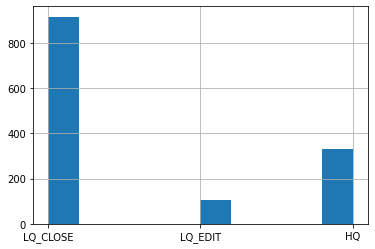

In [ ]:
roberta_incorrect_predictions["Y"].hist()

In [ ]:
roberta_incorrect_predictions.head()

,Title,Body,Tags,Y,Predicted
43179,how to uninstall bluej? is netbeans better?,"can i have intalled on my computer both bluej and netbeans? i have bluej now, if i uninstall it , everything related with it will be unistalled to (every libraries). and generally is netbeans better option?",java netbeans bluej,LQ_CLOSE,HQ
7354,ie8 - media query is not rendering,i've got very curious case in ie8 where media query is not working on url (mobile view shows on desktop) but if i use ip address than it works (desktop view shows). i tried a whole lot of things even several solutions from stackoverflow but couldn't succeed. it seems like respond.js issue but i'm not sure. can anyone please help me on this. url: https://www.uhc.com/ ip: 149.111.148.170 fyi: i'm using ie 11 developer tool to check it on ie8.,javascript jquery html css responsive-design,LQ_CLOSE,HQ
34302,why the output is not logic ?,"let vacationspots = ['usa', 'uk', 'colombia']; for (let vacationspotindex = vacationspots.length - 1; vacationspotindex >= 0; vacationspotindex-- ) { console.log('i would love to visit ' + vacationspots[vacationspotindex]); } i suppose the lenght is 3 and we substract 1 so it equals to 2; so the index start is 2 and we substract 1 on every loop the probleme in the condition vacationspotindex >= 0 i suppose logicly it is vacationspotindex <= 0",javascript for-loop,LQ_EDIT,LQ_CLOSE
1561,r data-frame: get maximum of variable b condititional on variable a,"i am searching for an efficient and fast way to do the following: i have a data frame with, say, 2 variables, a and b, where the values for a can occur several times: mat&lt;-data.frame('vara'=rep(seq(1,10),2),'varb'=rnorm(20)) vara varb 1 0.95848233 2 -0.07477916 3 2.08189370 4 0.46523827 5 0.53500190 6 0.52605101 7 -0.69587974 8 -0.21772252 9 0.29429577 10 3.30514605 1 0.84938361 2 1.13650996 3 1.25143046 now i want to get a vector giving me for every unique value of vara unique(mat$vara) the maximum of varb conditional on vara. in the example here that would be 1 0.95848233 2 1.13650996 3 2.08189370 etc... my data-frame is very big so i want to avoid the use of loops.",r dataframe,LQ_CLOSE,HQ
13995,run atexit() when python process is killed,"i have a python process which runs in background, and i would like it to generate some output only when the script is terminated. def handle_exit(): print('\nall files saved in ' + directory) generate_output() atexit.register(handle_exit) calling raising a keyboardinterupt exception and sys.exit() calls handle_exit() properly, but if i were to do kill {pid} from the terminal it terminates the script without calling handle_exit(). is there a way to terminate the process that is running in the background, and still have it run handle_exit() before terminating?",python background-process atexit,HQ,LQ_CLOSE


[('=', 2807),
 ('{', 2036),
 ('}', 1940),
 ('public', 653),
 ('new', 585),
 ('return', 527),
 ('using', 524),
 ('like', 459),
 ('string', 441),
 ('use', 436),
 ('code', 409),
 ('|', 395),
 ('want', 392),
 ('//', 386),
 ('+', 365),
 ('get', 359),
 ('class', 359),
 ("i'm", 349),
 ('function', 343),
 ('python', 338)]

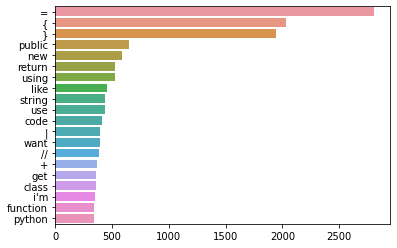

In [ ]:
plot_top_non_stopwords(roberta_incorrect_predictions["Title"] + " " + roberta_incorrect_predictions["Body"] + " " + roberta_incorrect_predictions["Tags"], 20)

[('=', 27290),
 ('{', 18847),
 ('}', 18097),
 ('using', 5468),
 ('new', 5237),
 ('code', 4510),
 ('want', 4407),
 ('return', 4366),
 ('like', 4188),
 ('public', 4184),
 ('int', 4107),
 ('+', 4094),
 ('string', 4086),
 ('get', 3993),
 ("i'm", 3785),
 ('file', 3588),
 ('use', 3462),
 ('//', 3414),
 ('-', 3342),
 (':', 3326)]

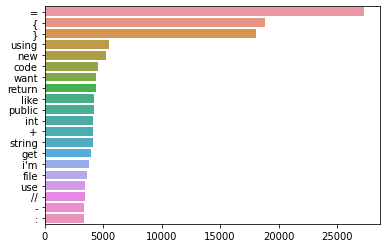

In [ ]:
plot_top_non_stopwords(roberta_correct_predictions["Title"] + " " + roberta_correct_predictions["Body"] + " " + roberta_correct_predictions["Tags"], 20)